In [25]:
import random
import nni
import numpy as np

import io
import graphviz
import matplotlib.pyplot as plt
from PIL import Image

import json
import os

In [2]:
DARTS_OPS = [
        # 'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

Создание архитектуры

In [ ]:
def extract_cells(arch_dict):
    normal_cell = {}
    reduction_cell = {}
    
    for key, value in arch_dict.items():
        if key.startswith('normal/'):
            normal_cell[key] = value
        elif key.startswith('reduce/'):
            reduction_cell[key] = value
    
    return normal_cell, reduction_cell

def generate_cells(num_nodes, name='normal', operations=DARTS_OPS):
    cells = dict()
    for i in range(num_nodes - 1):
        cur_indexes = list(range(0, i + 2))
        random_op_0, random_op_1 = random.choices(operations, k=2)
        
        random_index_0, random_index_1 = random.sample(cur_indexes, k=2)
        
        op_str_0 = f'{name}/op_{i + 2}_0'
        op_str_1 = f'{name}/op_{i + 2}_1'
        input_str_0 = f'{name}/input_{i + 2}_0'
        input_str_1 = f'{name}/input_{i + 2}_1'
        
        cells[op_str_0] = random_op_0
        cells[input_str_0] = [random_index_0]
        cells[op_str_1] = random_op_1
        cells[input_str_1] = [random_index_1]
        
    return cells

Визуализация

In [ ]:
def plot_single_cell(arch_dict, cell_name):
    g = graphviz.Digraph(
        node_attr=dict(style='filled', shape='rect', align='center'),
        format='png'
    )
    g.body.extend(['rankdir=LR'])

    g.node('c_{k-2}', fillcolor='darkseagreen2')
    g.node('c_{k-1}', fillcolor='darkseagreen2')

    max_nodes = max([int(key.split('_')[1]) for key in arch_dict.keys() if key.startswith(f'{cell_name}/op_')])

    for i in range(2, max_nodes + 1):
        g.node(str(i), fillcolor='lightblue')

    for i in range(2, max_nodes + 1):
        for j in range(2):
            op = arch_dict[f'{cell_name}/op_{i}_{j}']
            from_ = arch_dict[f'{cell_name}/input_{i}_{j}']
            
            if from_ == [0]:
                u = 'c_{k-2}'
            elif from_ == [1]:
                u = 'c_{k-1}'
            else:
                u = str(from_)
            v = str(i)
            g.edge(u, v, label=op, fillcolor='gray')

    g.node('c_{k}', fillcolor='palegoldenrod')
    for i in range(2, max_nodes + 1):
        g.edge(str(i), 'c_{k}', fillcolor='gray')

    g.attr(label=f'{cell_name.capitalize()} cell')

    image = Image.open(io.BytesIO(g.pipe()))
    return image

def plot_cells(arch_dict, cell_names):
    images = [plot_single_cell(arch_dict, cell_name) for cell_name in cell_names]
    
    height_ratio = max(image.size[1] / image.size[0] for image in images)
    
    _, axs = plt.subplots(1, len(images), figsize=(20 * len(images), 10 * height_ratio))
    
    if len(images) == 1:
        axs = [axs]
    
    for ax, image in zip(axs, images):
        ax.imshow(image)
        ax.axis('off')

    plt.show()

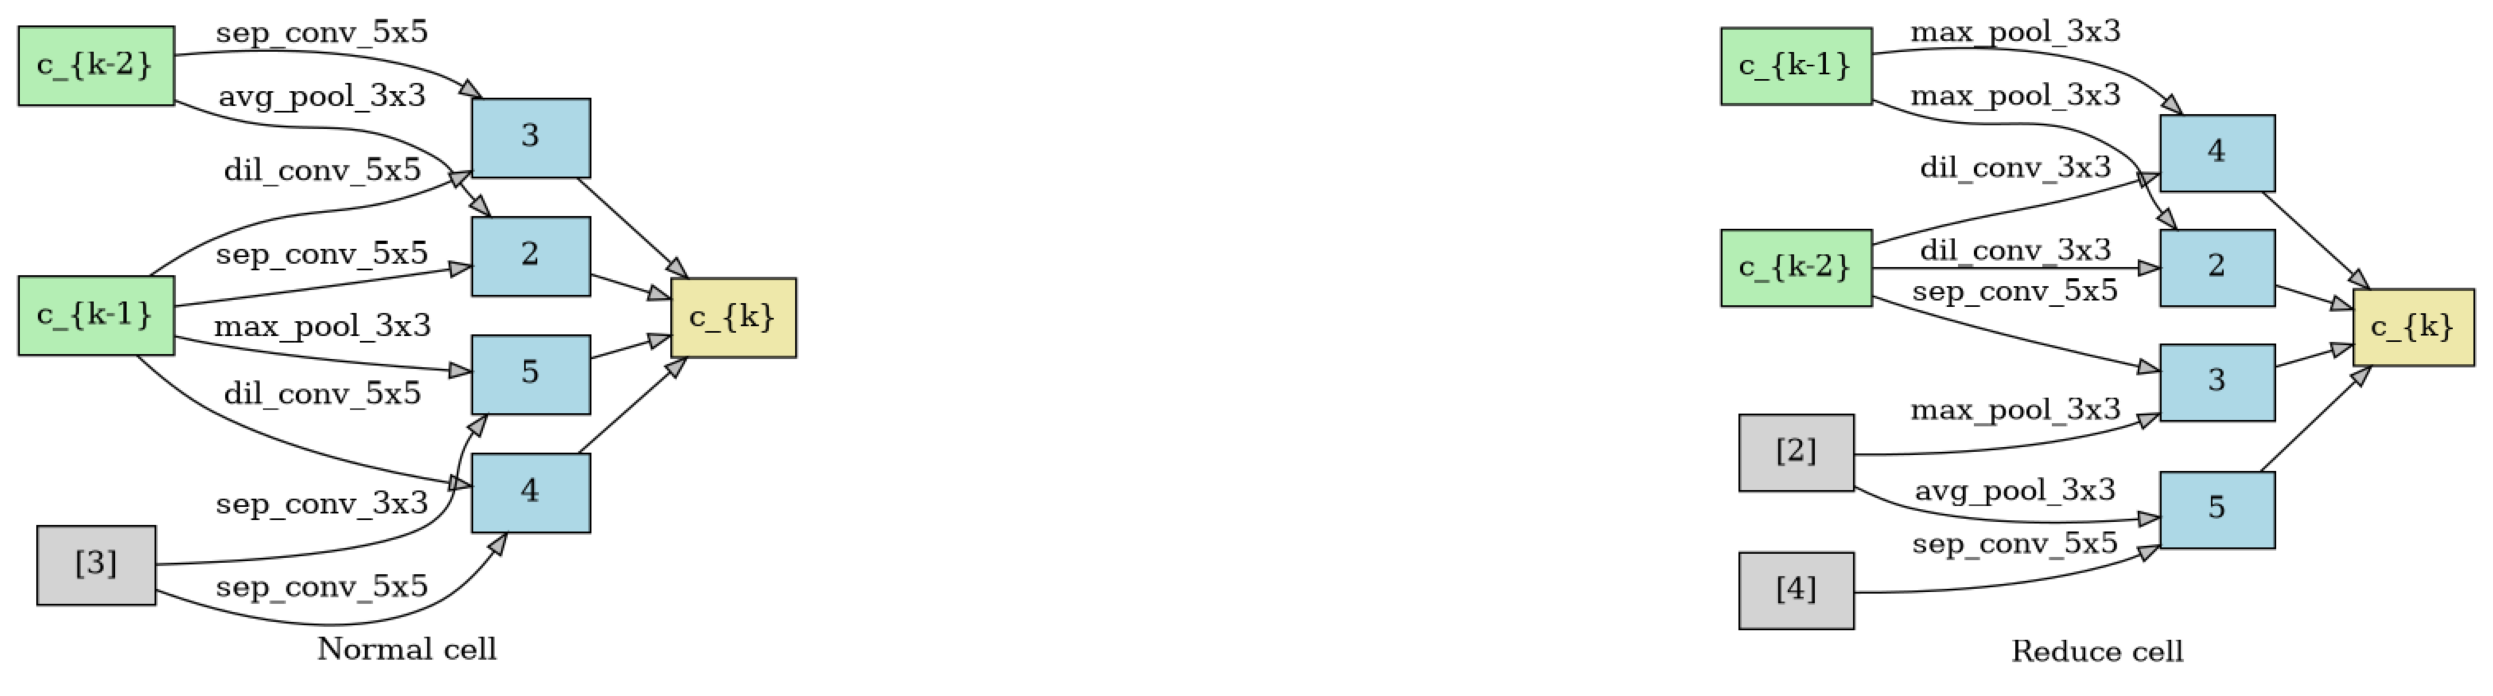

In [24]:
normal_cell = generate_cells(5, name='normal')
reduction_cell = generate_cells(5, name='reduce')
arch_dict = {**normal_cell, **reduction_cell}
plot_cells(arch_dict, ['normal', 'reduce'])

Создание архитектур.

In [29]:
os.makedirs('dataset', exist_ok=True)
N = 1000

arch_dicts = []
for _ in range(N):
    normal_cell = generate_cells(5, name='normal')
    reduction_cell = generate_cells(5, name='reduce')
    arch_dict = {**normal_cell, **reduction_cell}
    arch_dicts.append(arch_dict)

# Save to JSON file in the dataset directory
with open('dataset/arch_dicts.json', 'w') as f:
    json.dump(arch_dicts, f)

Загружает датасет

In [30]:
def load_arch_dicts(json_path):
    with open(json_path, 'r') as f:
        arch_dicts = json.load(f)
    return arch_dicts

# Пример использования:
arch_dicts = load_arch_dicts('dataset/arch_dicts.json')
arch_dicts

[{'normal/op_2_0': 'max_pool_3x3',
  'normal/input_2_0': [0],
  'normal/op_2_1': 'max_pool_3x3',
  'normal/input_2_1': [1],
  'normal/op_3_0': 'max_pool_3x3',
  'normal/input_3_0': [1],
  'normal/op_3_1': 'sep_conv_3x3',
  'normal/input_3_1': [2],
  'normal/op_4_0': 'dil_conv_5x5',
  'normal/input_4_0': [0],
  'normal/op_4_1': 'skip_connect',
  'normal/input_4_1': [3],
  'normal/op_5_0': 'sep_conv_3x3',
  'normal/input_5_0': [1],
  'normal/op_5_1': 'sep_conv_5x5',
  'normal/input_5_1': [3],
  'reduce/op_2_0': 'avg_pool_3x3',
  'reduce/input_2_0': [1],
  'reduce/op_2_1': 'sep_conv_5x5',
  'reduce/input_2_1': [0],
  'reduce/op_3_0': 'sep_conv_3x3',
  'reduce/input_3_0': [0],
  'reduce/op_3_1': 'avg_pool_3x3',
  'reduce/input_3_1': [2],
  'reduce/op_4_0': 'max_pool_3x3',
  'reduce/input_4_0': [3],
  'reduce/op_4_1': 'dil_conv_3x3',
  'reduce/input_4_1': [0],
  'reduce/op_5_0': 'sep_conv_5x5',
  'reduce/input_5_0': [1],
  'reduce/op_5_1': 'skip_connect',
  'reduce/input_5_1': [4]},
 {'norm